In [2]:
import matplotlib
import numpy as np
from scipy.stats import logistic
from scipy.optimize import minimize
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy.io
import gc
import datetime
import time
import mat73
import random
import matplotlib
import _spin_params as spin_pars
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, smooth_data, find_nearest_sorted_left, find_nearest_sorted
from _steady_state import a_steady, a_steady_with_sz
from _mbes import mbes, mbes_soc
from _do_calculation import solve_mbes, solve_mbes_cpmg, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay, solve_mbes_cpmg_time
# matplotlib.pyplot.switch_backend('nbagg')
# %qtconsole

In [53]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr
kappa = np.pi*fr/quali  # HWHM
delta = spin_pars.delta  # detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac  # detuning drive to cavity wc-wp
gperp = spin_pars.gperp  # HWHM
gpar = spin_pars.gpar  # 0.001 #HWHM
gammaq = spin_pars.gammaq/3
nbins = spin_pars.nbins  # 701#5000#20
g_number = spin_pars.g_number  # how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)

3.340878677112328


In [54]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)


x_start = 5
x_stop = 20  # µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

Text(0, 0.5, 'weight')

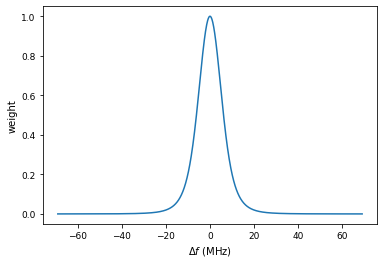

In [55]:
spins, gs, pdf = create_spins_inhomo_g(
    gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight')
# %qtconsole

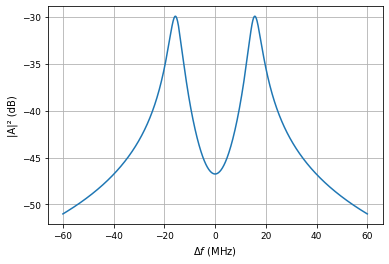

In [56]:
initsteady = (0.001, 0.001)
fstart = 60
deltaarr = np.linspace(-fstart*2*np.pi, fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))
gs_copl = gs[:len(pdf)]/np.linalg.norm(gs[:len(pdf)])*gcoll
newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs_copl,
                      spins[:len(pdf)], gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)')
plt.plot(-deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi
plt.grid(True)

In [57]:
pumptime = 40e-3  # 5*np.pi/gcoll
waittime = 200e-3
decaytime = 8000e-3
dt = 0.004
numsteps = int(pumptime/dt)
tlistpump = np.arange(0, pumptime, dt)
tlistdecay = np.arange(0, decaytime, dt)
tlistwait = np.arange(0, waittime, dt)


# test time it takes to calculate


init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1::2] = 0

### Linear Pulse

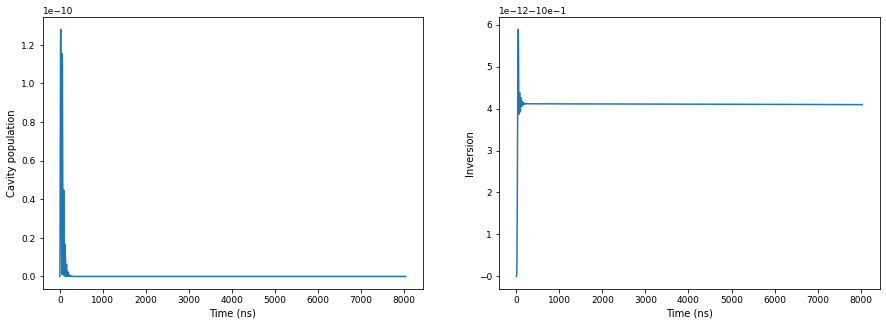

In [58]:
asolpump, asoldecay, infodict = solve_mbes(
    mbes, init, pdf, tlistpump, tlistdecay, 0.001, kappa, deltac, gs, gperp, spins, gpar)
alos_linear = np.hstack((abs(asolpump[:, 0])**2, abs(asoldecay[:, 0])**2))
szlos_linear = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(
    np.sum(asoldecay[:, 2::2], axis=1))))


tplot_linear = np.linspace(
    0, 1000*(pumptime+decaytime), len(tlistpump)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(tplot_linear, alos_linear)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Cavity population')

ax2.plot(tplot_linear, szlos_linear)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Inversion');

### Calibrate Power

In [59]:
pulsei = np.ones((len(tlistpump)))
pin = np.arange(-30, -16, 1)
aref = 3080

alos = np.zeros((len(pin), len(tlistpump)+len(tlistdecay)))
alosr = np.zeros((len(pin), len(tlistpump)+len(tlistdecay)))
alosi = np.zeros((len(pin), len(tlistpump)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))
szall = np.zeros((len(pin), len(tlistpump)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(alos))

for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    asolpump, asoldecay, infodict = solve_mbes(
        mbes, init, pdf, tlistpump, tlistdecay, dr, kappa, deltac, gs, gperp, spins, gpar)
    alos[ctr, :] = np.hstack((abs(asolpump[:, 0])**2, abs(asoldecay[:, 0])**2))
    alosr[ctr, :] = np.hstack((asolpump[:, 0].real, asoldecay[:, 0].real))
    alosi[ctr, :] = np.hstack((asolpump[:, 0].imag, asoldecay[:, 0].imag))
    szlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(
        np.sum(asoldecay[:, 2::2], axis=1))))
    szall[ctr, :, :] = np.vstack(
        (np.real(asolpump[:, 2::2]), np.real(asoldecay[:, 2::2])))
    small[ctr, :, :] = np.vstack(
        (np.real(asolpump[:, 1::2]), np.real(asoldecay[:, 1::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(
        np.sum(asoldecay[:, 1::2], axis=1))))

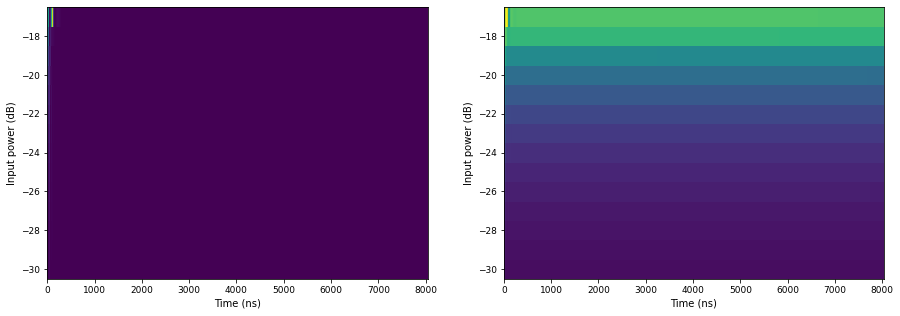

In [60]:
tplot = np.linspace(0, 1000*(pumptime+decaytime),
                    len(tlistpump)+len(tlistdecay))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.pcolor(tplot, pin, alos, shading="auto")
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)')

ax2.pcolor(tplot, pin, szlos, shading="auto")
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)')
maxAmpl = abs(asolpump).max()

### CPMG sequence

In [68]:
ptest = -5
drive = aref*10**(ptest/20.)
solpump, solwait, solpump2, soldecay, infodict = solve_mbes_cpmg_time(
    mbes, init, pdf, tlistpump, tlistwait, tlistdecay, drive, kappa, deltac, gs, gperp, spins, gpar)
asol2 = np.hstack((abs(solpump[:, 0])**2, abs(solwait[:, 0])
                  ** 2, abs(solpump2[:, 0])**2, abs(soldecay[:, 0])**2))
tplot = np.linspace(0, 3*pumptime + decaytime + waittime, len(asol2))

Text(0, 0.5, '$|a|^2$')

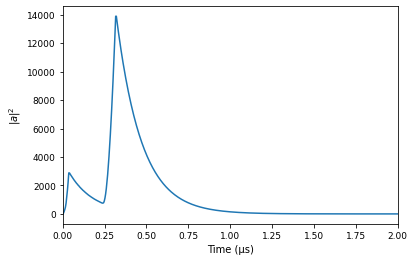

In [69]:
plt.plot(tplot, asol2)
#plt.ylim([0, 2e-16])
plt.xlim([0, 2])
plt.xlabel("Time (µs)")
plt.ylabel("$|a|^2$")

### scanning waittime

In [189]:
waittimes = np.arange(100e-3, 2200e-3, 100e-3)
ampls = np.zeros(waittimes.shape)

for i, wt in enumerate(waittimes):
    tlistwt = np.arange(0, wt, dt)
    solpump, solwait, solpump2, soldecay, infodict = solve_mbes_cpmg_time(
        mbes, init, pdf, tlistpump, tlistwt, tlistdecay, drive, kappa, deltac, gs, gperp, spins, gpar)
    asol2_wt = np.hstack((abs(solpump[:, 0])**2, abs(solwait[:, 0])
                         ** 2, abs(solpump2[:, 0])**2, abs(soldecay[:, 0])**2))
    tidx = np.linspace(0, 3*pumptime + decaytime + wt, len(asol2))
    valscan = pumptime+wt+2*pumptime+wt*0.8
    idx, value = find_nearest(tidx, valscan)
    ampls[i] = max(asol2_wt[idx:])


def exp_fit(x, a, b, c):
    return a*np.exp(-(x/b))


popt, pcov = scipy.optimize.curve_fit(
    exp_fit, waittimes, ampls, p0=[0.8, 0.2, 1])

/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[2.37310316 0.20167275 1.        ]
1.0202239941788163


Text(0, 0.5, 'Echo amplitudes')

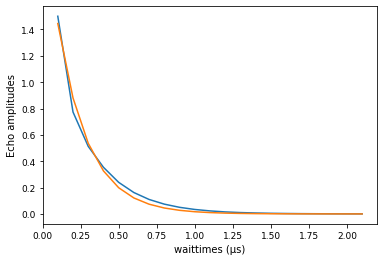

In [190]:
print(popt)
print(1/gperp)
plt.plot(waittimes, ampls)
plt.plot(waittimes, exp_fit(waittimes, *popt))
plt.xlabel('waittimes (µs)')
plt.ylabel("Echo amplitudes")

### Compare with data

In [110]:
file_scan = "/mnt/samba2/experiments/Quantum InterConnect/Cryogenics/Dilution Fridge/Measurements/20210124_DoulbeChipRes_10/timeResolved/scan_CPMG//SCRIPT_CPMG_1/scan_CPMG_5.mat"
data_ps = mat73.loadmat(file_scan)
scan_values_ps = np.asarray(np.squeeze(data_ps['scan_values']), dtype=float)
iq_data_ps = np.asarray(data_ps['IQdata_scan'])
iq_data_ps = np.asarray([val for val in iq_data_ps])
pl_idx = 5500
idx_s = 1790
wait_time_scan = 3e-7


hori = float(data_ps['pars']['acqiris']['acqirisStruct']
             ['horizontal']['sampInterval'])*1e9

idx, value = find_nearest(scan_values_ps, wait_time_scan)
a2plot = (iq_data_ps[idx, idx_s:pl_idx, 0]**2 +
          iq_data_ps[idx, idx_s:pl_idx, 1]**2)
aplotr = iq_data_ps[idx, idx_s:pl_idx, 0]
aploti = iq_data_ps[idx, idx_s:pl_idx, 1]
t_data = np.linspace(0, len(a2plot)*hori, len(a2plot))

ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:ro

(0.0, 2.0)

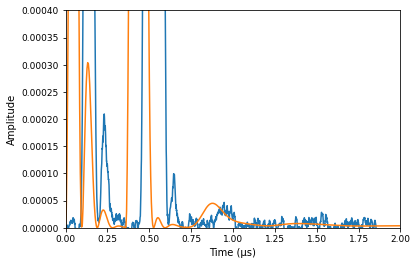

In [121]:
plt.plot(t_data/1000, smooth_data(a2plot, 25)-2e-5)
plt.plot(tplot, asol2*0.0002)
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude")
plt.ylim([0, 0.0004])
plt.xlim([0, 2])